# Using variational EM-type procedure to maximize J1

## $\nabla_{w}J_1(w)$ - general case

In the normalised-MOG notebook, we considered an EM-type algorithm where we update a variational distribution to be equal to the posterior over latent variables given the data and current value of $\theta$. Now let's pretend (as is generally true) that the posterior is intracable. In this setting, we parameterise our variational distribution with parameters $w$, and optimise them in conjuction with theta (using co-oordinate ascent). 

To optimise our objective function w.r.t to $\textbf{w}$, we need to find the gradient of:

\begin{align}
J_1^k(\textbf{w}) = \color{red}{ - \mathbb{E}_{x} \mathbb{E}_{z \sim q(z \ | \ u; \textbf{w})} \left[ \log(1 + \frac{\nu}{r(x, z; \textbf{w})}) \right]} - \color{blue}{ \nu \mathbb{E}_{y}  \left[ \log(1 + \frac{1}{\nu} \mathbb{E}_{z \sim q(z \ | \ u; \textbf{w})}[r(y, z; \textbf{w})] ) \right]}
\end{align}

where 

$$ r(u,z, \textbf{w}) = \frac{\phi(u, z; \theta_k)}{q_k(z \ | \ u; \textbf{w}) p_y(u)}$$

Note that this is a *stochastic* optimisation problem, since we are differentiating w.r.t to parameters of q, but there is an expectation over q. This complicates the situation.

For simple q distributions, we might be able to analytically evaluate these expectations, and then take derivatives. For more complex distributions, we will need to use something else: perhaps a pathwise derivative estimator (http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/) or score function estimator (http://blog.shakirm.com/2015/11/machine-learning-trick-of-the-day-5-log-derivative-trick/).

## $\nabla_{w}J_1(w)$ - Mixture Model

For our gaussian mixture model, the binary latent variable must have a bernouilli distribution, and so we can analytically evaluate expectations with respect to it. 

We will consider a bernoulli distribution where the probability of $z = 0$ is given by a quadratic sigmoid. This functional form matches that of the true posterior, and so by optimising the parameters $w$, we hope to recover the true posterior.

$$ q(z=0 \ | \ u; \textbf{w}) = \sigma(\textbf{w}^T \tilde{\textbf{u}}) = \sigma(w_0 + w_1u + w_2u^2) $$

where $\sigma$ is the sigmoid function,  $\textbf{w}$ are the variational parameters and $\tilde{\textbf{u}} := (1, u, u^2)^T$. We recover the true posterior by setting:
$$ \textbf{w} = \left[-\log(\theta), \ 0, \ \frac{1}{2}(1 - \theta^{-2}) \right] $$
We will then alternate optimisation of $\theta$ and $\textbf{w}$ (i.e apply a form of coordinate ascent).

To calculate $\nabla_{\textbf{w}} J_1^k(\textbf{w})$, we first analytically evaluate the expectations. Doing this, we see that the blue term will no longer depend on q (since q was only introduced in the blue term for importance sampling, which we now undo). Hence, we only have to evaluate:

\begin{align}
\nabla_{\textbf{w}} J_1^k(\textbf{w}) & = \color{red}{\nabla_{\textbf{w}} \left[ -\mathbb{E}_x \sum_{i=1}^2 q(i \ | \ x; \textbf{w}) \log \left( 1 + \nu\frac{ q(i \ | \ x; \textbf{w}) p_y(x)}{\phi(x, i, \theta_k)} \right) \right]}
\end{align}

The gradient of a term inside the summation has the form:

\begin{align}
\nabla_{\textbf{w}} \left[ q_i(\textbf{w}) \log( 1 + a_iq_i(\textbf{w})) \right] = \left( \log( 1 + a_iq_i(\textbf{w})) + \frac{a_i q_i(\textbf{w})}{1 + a_i q_i(\textbf{w})} \right) \nabla_{\textbf{w}} q_i(\textbf{w})
\end{align}

Where we have simplified notation by setting: $q_i(\textbf{w}) = q(i \ | \ x; \textbf{w})$ and $ a_i = \nu \frac{p_y(x)}{\phi(x, i, \theta_k)}$.

Observe that 

$$\nabla_{\textbf{w}} q_1(\textbf{w}) =  \nabla_{\textbf{w}} \left[ 1 - q_0(\textbf{w}) \right] = - \nabla_{\textbf{w}} q_0(\textbf{w}) $$

and so our original gradient becomes:

\begin{align}
\nabla_{\textbf{w}} J_1^k(\textbf{w}) 
    & = \color{red}{ \mathbb{E}_x  \left( \log \left( \frac{ 1 + a_0q_0(\textbf{w})}{1 + a_1q_1(\textbf{w})} \right) 
        +\frac{a_0 q_0(\textbf{w})}{1 + a_0 q_0(\textbf{w})} 
        -\frac{a_1 q_1(\textbf{w})}{1 + a_1 q_1(\textbf{w})}  \right) 
          \nabla_{\textbf{w}} q_1(\textbf{w})}
\end{align}

where, using the definition of $q$, we have:

\begin{align} 
\nabla_{\textbf{w}} q_0(\textbf{w}) & = \nabla_{\textbf{w}} q(z=0 \ | \ x; \textbf{w}) \\
& = \nabla_{\textbf{w}} \left[ \sigma(\textbf{w}^T \tilde{\textbf{x}}) \right] \\
& = \sigma(\textbf{w}^T \tilde{\textbf{x}}) (1 - \sigma(\textbf{w}^T \tilde{\textbf{x}})) \tilde{\textbf{x}}
\end{align}

Note that the above derivation actually applies to **any binary latent variable model**.

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import numpy as np
import pdb

# my code
from distribution import PolynomialSigmoidBernoulli, GaussianNoise
from gaussian_mixture_analytic_expectations import *
from latent_nce_optimiser import LatentNCEOptimiserWithAnalyticExpectations
from latent_variable_model import MixtureOfTwoGaussians

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

In [3]:
# For reproducibility
rng = rnd.RandomState(1083463236)

In [4]:
# mixing proportions: 0.5 and 0.5
# mean0 = mean1 = 0
sigma1 = 1
sigma0 = 4  # (parameter of interest)

n = 10000 # number of data points
nz = 1  # number of latent samples per datapoint
nu = 5 # nu is the ratio of noise to data samples in NCE

theta0 = 0.5  # initial theta

In [5]:
true_data_dist = MixtureOfTwoGaussians(theta=np.log(sigma0), sigma1=sigma1)
X = true_data_dist.sample(n) # generate data

In [6]:
model = MixtureOfTwoGaussians(theta0, sigma1=sigma1)
noise = GaussianNoise(mean=0, std = sigma0)
var_dist = PolynomialSigmoidBernoulli(alpha=np.array([0,0,0]))

In [7]:
# E(r(x, z))
E1 = E_r
# E(log(psi_1(x, z)))
E2 = E_log_psi_1
# E((psi_1(x, z) - 1) / psi_1(x, z))
E3 = E_psi_1_ratio_times_grad_log_theta
# E(grad_theta(log(phi(u,z)) r(u, z))
E4 = E_r_times_grad_log_theta
# gradient_alpha(E(log(psi_1(x, z)))
E5 = grad_wrt_alpha_of_E_log_psi_1

In [8]:
optimiser = LatentNCEOptimiserWithAnalyticExpectations(model, noise, var_dist, n,
                                                       E1, E2, E3, E4, E5, 
                                                       nu=nu, latent_samples_per_datapoint=nz, eps = 10**-20)
Y = optimiser.Y

# Variational EM-type optimisation

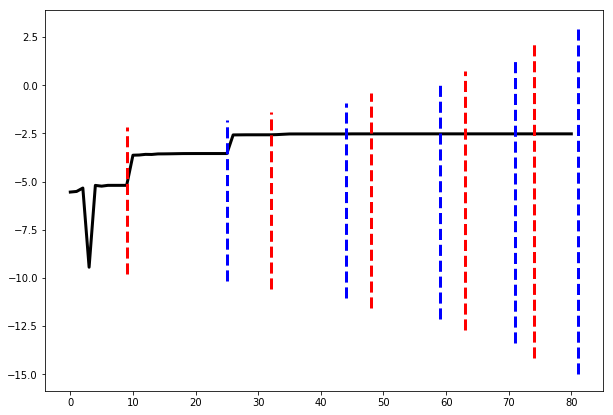

In [9]:
thetas_per_em, alpha_per_em, J1s, J1_grads = optimiser.fit(X, theta0=2, alpha0=np.array([-0.1,-0.1,-0.1]), 
                                                           disp=False, stop_threshold=10**-5)

### coordinate ascent visualisation

In [10]:
thetas = np.arange(0.01, 8, 0.1).reshape(-1, 1)
n_theta = len(thetas)

In [11]:
def h(u):
    return np.log(model.marginalised_over_z(u)) - np.log(noise(u))

J = np.zeros(n_theta)
for k in range(n_theta):
    model.theta = np.log(thetas[k])

    a0 = 1 + nu*np.exp(-h(X))
    a1 = 1 + (1/nu)*np.exp(h(Y))
    
    J[k] = -np.mean(np.log(a0)) - nu*np.mean(np.log(a1))

In [12]:
num_e_steps = len(thetas_per_em)  # includes initialisation
num_m_steps = len(alpha_per_em)  # includes intialisation
lower_bounds = [np.zeros(n_theta) for i in range(num_m_steps)]
for i in range(num_m_steps):
    var_dist.alpha = alpha_per_em[i]
    for j in range(n_theta):
        model.theta = np.log(thetas[j])
        lower_bounds[i][j] = optimiser.compute_J1(X)

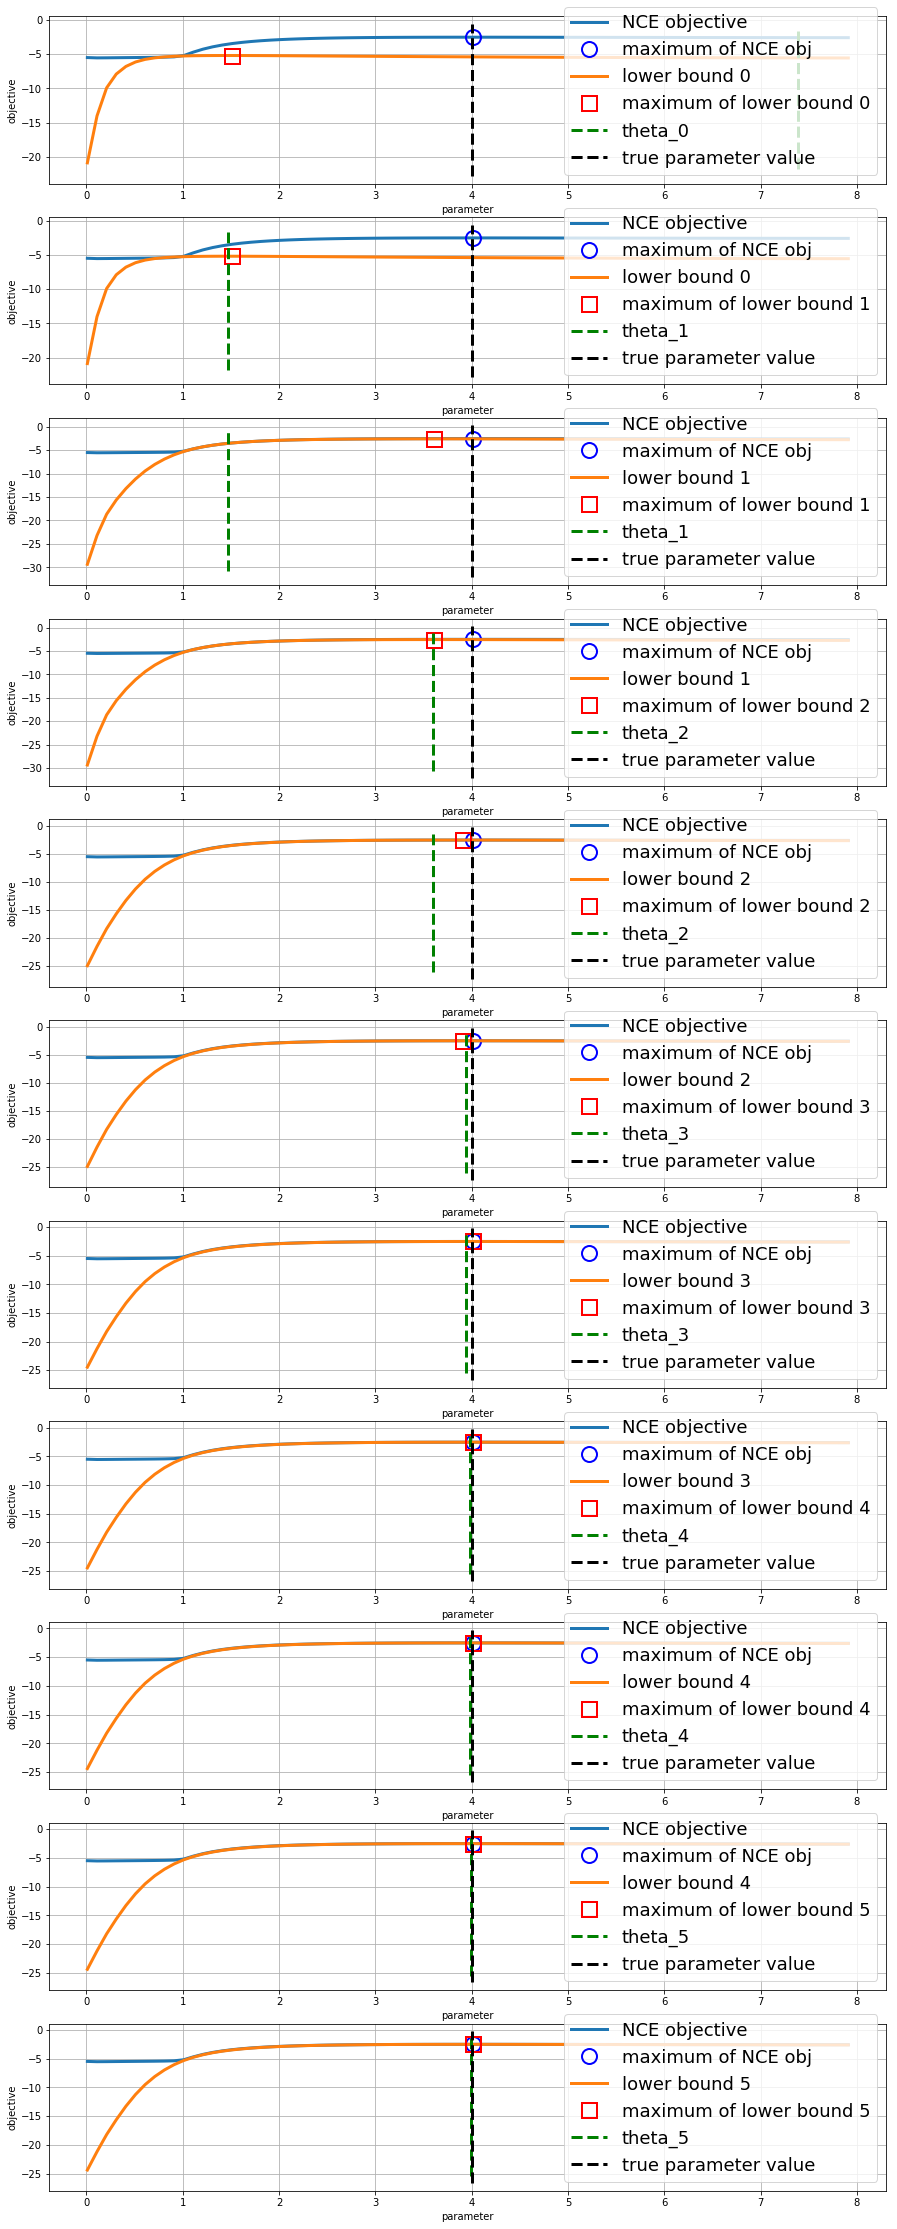

In [13]:
num_em_steps = num_e_steps + num_m_steps - 1  # minus 1 for double counting intialisation
fig, axs = plt.subplots(num_em_steps, 1, figsize=(15, 40))
axs = axs.ravel()

for i in range(num_em_steps):
    # plot NCE objective and its maximum
    axs[i].plot(thetas, J, label='NCE objective')
    J_index = np.argmax(J)
    axs[i].plot(thetas[J_index],J[J_index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='b', linestyle='none', label='maximum of NCE obj')
    
    # plot current lower bound J1
    lb = lower_bounds[int(i/2)]
    axs[i].plot(thetas, lb, label='lower bound {}'.format(int(i/2)))
   
    # maximiser of lower bound
    lb_index = np.argmax(lb)
    axs[i].plot(thetas[lb_index], lb[lb_index], 'rs', markersize=15, fillstyle='none', 
             markeredgewidth=2, linestyle='none', label='maximum of lower bound {}'.format(int(np.ceil(i/2))))
    
    # current theta value
    axs[i].plot(np.exp(thetas_per_em[int(np.ceil(i/2))]) * np.array([1,1]),
                plt.get(axs[i],'ylim'), 'g--', label='theta_{}'.format(int(np.ceil(i/2))))
    # true param value
    axs[i].plot(sigma0 * np.array([1,1]), plt.get(axs[i],'ylim'), 'k--', label='true parameter value')

    axs[i].set_xlabel('parameter')
    axs[i].set_ylabel('objective')
    axs[i].legend(loc='lower right', numpoints=1)
    axs[i].grid()